In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
#stopwords = set(STOPWORDS)
import itertools
import nltk
# nltk.download()
# nltk.download('stopwords')
# nltk.download("punkt")
# nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk import ne_chunk
from nltk.util import ngrams
from nltk.book import *

import plotly
import plotly.express as px

import re
import string



#read the files
train = pd.read_csv("/Users/legfot/Documents/content/data/train.csv", encoding = 'ISO-8859-1')
test = pd.read_csv("/Users/legfot/Documents/content/data/test.csv", encoding = 'ISO-8859-1')
test_y = pd.read_csv("/Users/legfot/Documents/content/data/test_labels.csv", encoding = 'ISO-8859-1')

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [2]:

stop = stopwords.words('english')

train['preprocess'] = train.apply(lambda row: row['comment_text'].replace("\n"," "), axis=1) #removes new line character
test['preprocess'] = test.apply(lambda row: row['comment_text'].replace("\n"," "), axis=1)

#removes urls
train['preprocess']=train.apply(lambda row: re.sub('http://\S+|https://\S+', 'urls',row['preprocess']).lower(), axis=1)
test['preprocess']=test.apply(lambda row: re.sub('http://\S+|https://\S+', 'urls',row['preprocess']).lower(), axis=1)

#remove all non-alphanumeric values(Except single quotes)
train['preprocess']=train.apply(lambda row: re.sub('[^A-Za-z\' ]+', '',row['preprocess']).lower(), axis=1)
test['preprocess']=test.apply(lambda row: re.sub('[^A-Za-z\' ]+', '',row['preprocess']).lower(), axis=1)

#remove stopwords as they occupy major chunk of the vocabulary
train['preprocess'] = train['preprocess'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test['preprocess'] = test['preprocess'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#removes all additional spaces
train['preprocess']=train.apply(lambda row: re.sub('  +', ' ',row['preprocess']).strip(), axis=1)
test['preprocess']=test.apply(lambda row: re.sub('  +', ' ',row['preprocess']).strip(), axis=1)

In [3]:
train["preprocess1"] = train.apply(lambda x: x["comment_text"] if len(x["preprocess"])==0 else x['preprocess'], axis=1)
test["preprocess1"] = test.apply(lambda x: x["comment_text"] if len(x["preprocess"])==0 else x['preprocess'], axis=1)
traindf=train[['preprocess1','toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
testdf=test[['id','preprocess1']]

In [7]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

In [5]:
traind=traindf["preprocess1"]
train_label=traindf[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
testd=testdf["preprocess1"]

#prepare tokenizer
tokenizer = Tokenizer(num_words = 30000) #only 30000 words i am considering here
tokenizer.fit_on_texts(traind)

#convert each text into array of integers with help of tokenizer.
train_final = tokenizer.texts_to_sequences(traind)
test_final = tokenizer.texts_to_sequences(testd)
#Now lets pad the sentences. 
#From the above histogram it is evident that most of sentences falling in range 1-200 lengths. 
#max length=200 is kept 
#We will trim any sentence above that length and we will pad zeros for all the sentence below 200
traind=pad_sequences(train_final, maxlen=200)
testd=pad_sequences(test_final, maxlen=200)

In [37]:
import tensorflow as tf
MAX_FEATURES = 30000
MAX_SENTENCE_LENGTH = 200


def LSTM_model(lstm_units, dropout_rate):
    model = Sequential([
        tf.keras.layers.InputLayer(input_shape=(MAX_SENTENCE_LENGTH,)),
        tf.keras.layers.Embedding(input_dim=MAX_FEATURES, output_dim=int(MAX_FEATURES ** 0.25)),
        tf.keras.layers.LSTM(units=lstm_units),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(6, activation=tf.nn.sigmoid)
    ])
    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        metrics=['accuracy']
    )
    return model

# define some hyper parameters
batch_size = 32
epochs = 2
lstm_units = 50
dropout_rate = 0.5

# define the model
LSTM_model = LSTM_model(lstm_units, dropout_rate)
print(model.summary())

# define some callbacks
checkpoint_cb = ModelCheckpoint(filepath='model_toxic/cp.ckpt',
                                save_weights_only=True,
                                mode='min',
                                verbose=1,
                                save_best_only=True)
tensorboard_cb = TensorBoard(log_dir='model_toxic',
                             histogram_freq=1,
                             write_grads=True)

# start train and evaluate
LSTM_model_history = LSTM_model.fit(
                x=traind,
                y=train_label,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.2,
                callbacks=[checkpoint_cb, tensorboard_cb],
            )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 13)           390000    
                                                                 
 lstm_2 (LSTM)               (None, 50)                12800     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 306       
                                                                 
Total params: 403,106
Trainable params: 403,106
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2


2023-01-11 17:48:45.395050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-11 17:48:45.927666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-11 17:48:46.645920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3990/3990 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9504

2023-01-11 17:53:20.085655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-11 17:53:20.195875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.12407, saving model to model_toxic/cp.ckpt
3990/3990 [==============================] - 298s 74ms/step - loss: 0.1381 - accuracy: 0.9504 - val_loss: 0.1241 - val_accuracy: 0.9933
Epoch 2/2
3990/3990 [==============================] - ETA: 0s - loss: 0.1139 - accuracy: 0.9889
Epoch 00002: val_loss improved from 0.12407 to 0.10220, saving model to model_toxic/cp.ckpt
3990/3990 [==============================] - 317s 79ms/step - loss: 0.1139 - accuracy: 0.9889 - val_loss: 0.1022 - val_accuracy: 0.9916


NameError: name 'vloss' is not defined

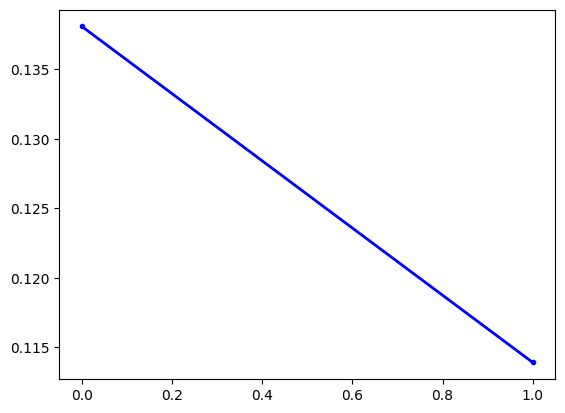

In [38]:
loss = LSTM_model_history.history['loss']

#x_len = np.arange(len(loss))
#plt.plot(x_len, vloss, marker='.', lw=2.0, c='red', label='val')
#plt.plot(x_len, loss, marker='.', lw=2.0, c='blue', label='train')
plt.figure()
plt.plot(loss, marker='.', lw=2.0, c='blue', label='train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.grid()
plt.show()

In [54]:
plt.figure()
plt.plot(LSTM_model_history.history['accuracy'], marker='.', c='red', label='val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.show()

NameError: name 'LSTM_model_history' is not defined

<Figure size 640x480 with 0 Axes>

In [44]:
LSTM_result = testdf[['id']]
LSTM_preds = LSTM_model.predict(testd)
LSTM_result[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = LSTM_preds
LSTM_result.to_csv("result_LSTM.csv", index = False)

2023-01-11 18:02:05.120905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-11 18:02:05.259222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [50]:
import tensorflow as tf
import tensorflow.keras as keras
def GRU_model(lstm_units, dropout_rate):
    GRU_model = Sequential([
        keras.layers.InputLayer(input_shape=(MAX_SENTENCE_LENGTH,)),
        keras.layers.Embedding(input_dim=MAX_FEATURES, output_dim=int(MAX_FEATURES ** 0.25)),
        keras.layers.GRU(units=lstm_units),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(6, activation=tf.nn.sigmoid)
    ])
    GRU_model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        metrics=['accuracy']
    )
    return GRU_model

# define some hyper parameters
batch_size = 32
epochs = 2
lstm_units = 50
dropout_rate = 0.5

# define the model
GRU_model = GRU_model(lstm_units, dropout_rate)
print(GRU_model.summary())

# define some callbacks
checkpoint_cb = ModelCheckpoint(filepath='model_toxic/cp.ckpt',
                                save_weights_only=True,
                                mode='min',
                                verbose=1,
                                save_best_only=True)
tensorboard_cb = TensorBoard(log_dir='model_toxic',
                             histogram_freq=1,
                             write_grads=True)

# start train and evaluate
GRU_model_history = GRU_model.fit(
                x=traind,
                y=train_label,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.2,
                callbacks=[checkpoint_cb, tensorboard_cb],
            )

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 200, 13)           390000    
                                                                 
 gru_5 (GRU)                 (None, 50)                9750      
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 6)                 306       
                                                                 
Total params: 400,056
Trainable params: 400,056
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2


2023-01-11 18:36:00.640222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-11 18:36:00.995253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-11 18:36:01.667049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3990/3990 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9397

2023-01-11 18:40:38.761192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-11 18:40:38.929872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.07801, saving model to model_toxic/cp.ckpt
3990/3990 [==============================] - 306s 76ms/step - loss: 0.1031 - accuracy: 0.9397 - val_loss: 0.0780 - val_accuracy: 0.9681
Epoch 2/2
3990/3990 [==============================] - ETA: 0s - loss: 0.0809 - accuracy: 0.9492
Epoch 00002: val_loss did not improve from 0.07801
3990/3990 [==============================] - 299s 75ms/step - loss: 0.0809 - accuracy: 0.9492 - val_loss: 0.0808 - val_accuracy: 0.9773


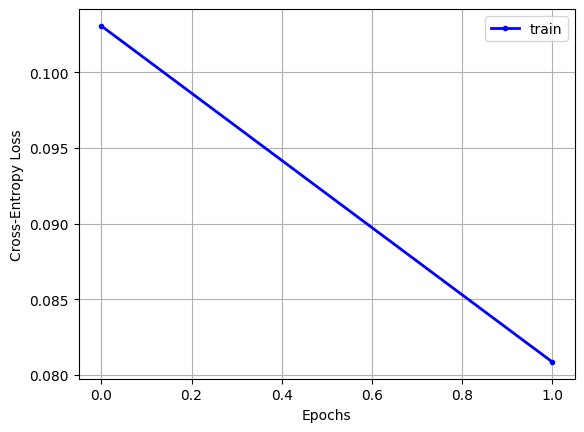

In [51]:
Gloss = GRU_model_history.history['loss']

#x_len = np.arange(len(loss))
#plt.plot(x_len, vloss, marker='.', lw=2.0, c='red', label='val')
#plt.plot(x_len, loss, marker='.', lw=2.0, c='blue', label='train')
plt.figure()
plt.plot(Gloss, marker='.', lw=2.0, c='blue', label='train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.grid()
plt.show()

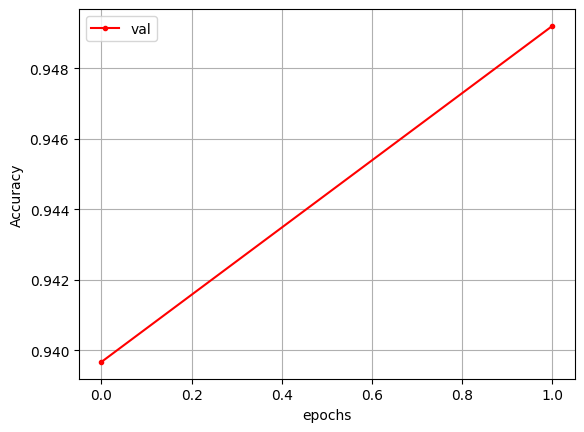

In [53]:
plt.figure()
plt.plot(GRU_model_history.history['accuracy'], marker='.', c='red', label='val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.show()

In [55]:
GRU_result = testdf[['id']]
GRU_preds = GRU_model.predict(testd)
GRU_result[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = GRU_preds
GRU_result.to_csv("result_GRU.csv", index = False)

2023-01-11 18:57:43.049334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-01-11 18:57:43.225259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [57]:
LSTM_result

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.010622,0.000032,0.002704,4.686829e-06,0.002007,0.000069
1,0000247867823ef7,0.056379,0.000982,0.020023,2.931993e-04,0.019213,0.001890
2,00013b17ad220c46,0.049274,0.003632,0.033501,7.919517e-04,0.025712,0.003386
3,00017563c3f7919a,0.003306,0.000003,0.000594,3.038785e-07,0.000456,0.000008
4,00017695ad8997eb,0.040610,0.000371,0.014727,5.493087e-05,0.011600,0.000493
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.191648,0.009699,0.104382,2.439720e-03,0.094987,0.011140
153160,fffd7a9a6eb32c16,0.035808,0.000496,0.011523,1.699445e-04,0.010624,0.001185
153161,fffda9e8d6fafa9e,0.020560,0.000182,0.005705,6.214662e-05,0.005346,0.000517
153162,fffe8f1340a79fc2,0.035868,0.000528,0.011663,1.924248e-04,0.010924,0.001328
